### Fine tune LLM embeedings model


In [2]:
#!pip install openai==0.28.1
#!pip install openai --upgrade
#!pip install ragas
#!pip install unstructured
#!pip install langchain[all]
#!pip install --upgrade langchain

#!pip install playwright
#!pip install -U selenium unstructured
#!pip install --upgrade langchain langchain-community langchainhub langchain-openai langchain-chroma bs4

In [1]:
#!pip install pydantic==2.5
#!pip install --upgrade --quiet  langchain_milvus
#!pip install --upgrade scipy

In [1]:
#!pip install -U langchain-openai

In [1]:
#!pip install llama-index-embeddings-langchain

In [1]:
import os, json
import pandas as pd
#import openai
#from langchain.chat_models import ChatOpenAI, ChatGooglePalm
from utils import OPENAI_API_KEY

os.environ['OPENAI_API_KEY'] =  OPENAI_API_KEY
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
from naive_rag import NaiveRAG 
from contextual_rag import ContextualRAG

PDF_FOLDER = "./data"
## Initialize and Train Both RAG Systems

# Initialize both RAG systems with the same embedding model for fair comparison
embedding_model = "BAAI/bge-base-en-v1.5"
chunk_size = 2000
chunk_overlap = 200

naive_rag = NaiveRAG(
    embedding_model_name=embedding_model,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)

contextual_rag = ContextualRAG(
    embedding_model_name=embedding_model,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)

# Process PDFs with NaiveRAG
naive_chunks, naive_metadata = naive_rag.upload_files(PDF_FOLDER)
naive_rag.make_db(naive_chunks, naive_metadata)

# Process PDFs with ContextualRAG
chunks, chunk_metadata = contextual_rag.upload_files(PDF_FOLDER)
contextual_rag.make_db(chunks, chunk_metadata)

Using device: cuda
Loading embedding model: BAAI/bge-base-en-v1.5
Using device: cuda
Loading embedding model: BAAI/bge-base-en-v1.5
Loading PDF files from ./data
Loaded 78 documents
Created 119 text chunks from 5 documents


Generating embeddings: 100%|██████████████████| 119/119 [00:07<00:00, 16.67it/s]


Generated embeddings for 119 chunks
Created vector database with 119 entries
Loading PDF files from ./data
Loaded 78 documents
Created 119 text chunks from 5 documents
Creating vector databases...
Extracting keywords from chunks...


Extracting keywords: 100%|██████████████████| 119/119 [00:00<00:00, 2173.73it/s]


Extracted 634 unique keywords across 119 chunks
Generating token-level embeddings...


Generating chunk embeddings: 100%|████████████| 119/119 [00:06<00:00, 17.50it/s]


Generated token embeddings for 119 chunks
Generated token IDs for 119 chunks
Token embedding shape: torch.Size([423, 768]) and Type: <class 'torch.Tensor'>
Generating full chunk embeddings...
Generated 119 chunk embeddings using mean pooling
Generating keyword embeddings...


Generating keyword embeddings: 100%|██████████| 119/119 [00:05<00:00, 22.74it/s]


Generated embeddings for 3504 keyword-context-document pairs
Average 6.40 contexts per keyword
Generating keyword-based chunk embeddings...


Generating chunk embeddings: 100%|████████████| 119/119 [00:04<00:00, 23.87it/s]

Generated embeddings for 119 chunks
Found keywords in 119 chunks
Average 34.08 keywords per chunk with keywords
Creating keyword embedding database...
Creating chunk embedding database...
Creating keyword-based chunk embedding database...
Creating vector database for efficient similarity search...
Vector databases created with 3504 keyword embeddings, 119 chunk embeddings, and 119 keyword-chunk embeddings.


In [3]:
# Laod questions & answers
df_ground_true = pd.read_csv("../data/data_rag/QA_ai4mat_2articles.csv")

questions = df_ground_true['question'].values.tolist()
answers = df_ground_true['answer'].values.tolist()


In [16]:
from tqdm import tqdm
# You could also generate test queries using an LLM if you have access to one

## Run Queries on Both Systems

# We'll run each query through both RAG systems and collect the results.

naive_results = []
contextual_hybrid_results = []
contextual_keywords_only_results = []

for query in tqdm(questions, desc="Processing queries"):
    # Get results from naive RAG
    naive_result = naive_rag.process_query(query, top_k=10)
    naive_results.append(naive_result)
    
    # Get results from contextual RAG (hybrid mode)
    contextual_hybrid_result = contextual_rag.process_query(
        query, 
        top_k=10, 
        keyword_weight=0.1,  # Emphasize keyword matches
        chunk_weight=0.1,     # But also consider whole-chunk similarity
        keyword_chunk_weight=0.8,
    )
    contextual_hybrid_results.append(contextual_hybrid_result)
    
    # Get results from contextual RAG (keywords-only mode)
    contextual_keywords_result = contextual_rag.process_query(
        query, 
        top_k=10, 
        keyword_weight=0.8,  # Emphasize keyword matches
        chunk_weight=0.1,     # But also consider whole-chunk similarity
        keyword_chunk_weight=0.1,
    )
    contextual_keywords_only_results.append(contextual_keywords_result)

Processing queries:   0%|                                | 0/35 [00:00<?, ?it/s]

Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 2 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 2 query terms...


Processing queries:   3%|▋                       | 1/35 [00:00<00:12,  2.65it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 4 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 4 query terms...


Processing queries:   6%|█▎                      | 2/35 [00:01<00:18,  1.76it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 2 query terms...
Searching chunk database...
Searching keyword-chunk database...


Processing queries:   9%|██                      | 3/35 [00:01<00:14,  2.17it/s]

Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 2 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 3 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 3 query terms...


Processing queries:  11%|██▋                     | 4/35 [00:01<00:14,  2.17it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 3 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 3 query terms...


Processing queries:  14%|███▍                    | 5/35 [00:02<00:13,  2.18it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 2 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results


Processing queries:  17%|████                    | 6/35 [00:02<00:11,  2.46it/s]

Searching keyword database with 2 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 2 query terms...


Processing queries:  20%|████▊                   | 7/35 [00:02<00:10,  2.64it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 2 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 5 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 5 query terms...


Processing queries:  23%|█████▍                  | 8/35 [00:03<00:13,  2.00it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 6 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 6 query terms...


Processing queries:  26%|██████▏                 | 9/35 [00:04<00:16,  1.62it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 6 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 6 query terms...


Processing queries:  29%|██████▌                | 10/35 [00:05<00:18,  1.35it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 6 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 6 query terms...


Processing queries:  31%|███████▏               | 11/35 [00:06<00:19,  1.22it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 2 query terms...


Processing queries:  34%|███████▉               | 12/35 [00:06<00:15,  1.51it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 2 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 6 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 6 query terms...


Processing queries:  37%|████████▌              | 13/35 [00:07<00:16,  1.35it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 4 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 4 query terms...


Processing queries:  40%|█████████▏             | 14/35 [00:08<00:14,  1.41it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 2 query terms...
Searching chunk database...


Processing queries:  43%|█████████▊             | 15/35 [00:08<00:11,  1.68it/s]

Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 2 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 4 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 4 query terms...


Processing queries:  46%|██████████▌            | 16/35 [00:09<00:11,  1.66it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 2 query terms...
Searching chunk database...
Searching keyword-chunk database...


Processing queries:  49%|███████████▏           | 17/35 [00:09<00:09,  1.93it/s]

Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 2 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 5 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 5 query terms...


Processing queries:  51%|███████████▊           | 18/35 [00:10<00:11,  1.54it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 4 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 4 query terms...


Processing queries:  54%|████████████▍          | 19/35 [00:11<00:12,  1.30it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 3 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 3 query terms...


Processing queries:  57%|█████████████▏         | 20/35 [00:12<00:11,  1.35it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 2 query terms...
Searching chunk database...
Searching keyword-chunk database...


Processing queries:  60%|█████████████▊         | 21/35 [00:12<00:08,  1.60it/s]

Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 2 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 3 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 3 query terms...
Searching chunk database...
Searching keyword-chunk database...


Processing queries:  63%|██████████████▍        | 22/35 [00:13<00:07,  1.71it/s]

Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 3 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 3 query terms...


Processing queries:  66%|███████████████        | 23/35 [00:13<00:06,  1.80it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 5 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 5 query terms...


Processing queries:  69%|███████████████▊       | 24/35 [00:14<00:07,  1.54it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 7 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 7 query terms...


Processing queries:  71%|████████████████▍      | 25/35 [00:15<00:07,  1.25it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 4 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 4 query terms...


Processing queries:  74%|█████████████████      | 26/35 [00:16<00:06,  1.34it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 9 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 9 query terms...


Processing queries:  77%|█████████████████▋     | 27/35 [00:17<00:07,  1.03it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 4 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 4 query terms...


Processing queries:  80%|██████████████████▍    | 28/35 [00:18<00:06,  1.13it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 6 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 6 query terms...


Processing queries:  83%|███████████████████    | 29/35 [00:19<00:05,  1.10it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 4 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 4 query terms...


Processing queries:  86%|███████████████████▋   | 30/35 [00:20<00:04,  1.17it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 7 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 7 query terms...


Processing queries:  89%|████████████████████▎  | 31/35 [00:21<00:03,  1.05it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 6 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 6 query terms...


Processing queries:  91%|█████████████████████  | 32/35 [00:22<00:02,  1.04it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 5 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 5 query terms...


Processing queries:  94%|█████████████████████▋ | 33/35 [00:23<00:01,  1.08it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 23 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 23 query terms...
Searching chunk database...
Searching keyword-chunk database...


Processing queries:  97%|██████████████████████▎| 34/35 [00:27<00:01,  1.92s/it]

Retrieved 10 results
Retrieving: 1 keyword results, 1 chunk results, 8 keyword-chunk results
Searching keyword database with 3 query terms...
Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results
Retrieving: 8 keyword results, 1 chunk results, 1 keyword-chunk results
Searching keyword database with 3 query terms...


Processing queries: 100%|███████████████████████| 35/35 [00:28<00:00,  1.25it/s]

Searching chunk database...
Searching keyword-chunk database...
Retrieved 10 results


In [17]:
## Prepare Data for RAGAS Evaluation

# RAGAS requires data in specific format for evaluation.

from datasets import Dataset

from ragas.metrics import  (context_precision,
    context_recall,
    context_relevancy)

def prepare_ragas_data(queries, answers, retrieval_results):
    """
    Prepare data for RAGAS evaluation.
    
    Args:
        queries: List of query strings
        retrieval_results: List of retrieval results for each query
        
    Returns:
        Dataset in RAGAS format
    """
    data = {
        "question": [],
        'ground_truth': [],
        "contexts": [],
        # For a proper evaluation we'd need ground truth answers, but for now we'll skip answer evaluation
        # "answer": [],
        # "ground_truths": []
    }
    
    for query, answer, results in zip(queries, answers, retrieval_results):
        data["question"].append(query)
        data['ground_truth'].append(answer)
        # Extract text from results
        contexts = [result.get("text", result.get('chunk_text'))for result in results]
        data["contexts"].append(contexts)
        
        # We'd need actual LLM-generated answers and ground truths for a complete evaluation
        # data["answer"].append("")
        # data["ground_truths"].append([""])
    
    return Dataset.from_dict(data)

In [18]:
from ragas.evaluation import evaluate
# Prepare datasets for RAGAS
naive_dataset = prepare_ragas_data(questions, answers, naive_results)
contextual_hybrid_dataset = prepare_ragas_data(questions, answers, contextual_hybrid_results)
contextual_keywords_dataset = prepare_ragas_data(questions, answers, contextual_keywords_only_results)


In [19]:
## Evaluate with RAGAS

# Now we'll use RAGAS to evaluate the retrieval quality of each system.

# Since we're focused on retrieval quality, we'll use the retrieval metrics
metrics = [
    context_precision,
    context_recall,
    context_relevancy
]

# Evaluate NaiveRAG
print("Evaluating NaiveRAG...")
naive_results = evaluate(naive_dataset, metrics)

# Evaluate ContextualRAG (hybrid mode)
print("Evaluating ContextualRAG (hybrid mode)...")
contextual_hybrid_results = evaluate(contextual_hybrid_dataset, metrics)

# Evaluate ContextualRAG (keywords-only mode)
print("Evaluating ContextualRAG (keywords-only mode)...")
contextual_keywords_results = evaluate(contextual_keywords_dataset, metrics)

## Compare Results

# Function to extract metric scores
def get_metric_scores(result):
    return {
        "context_precision": result["context_precision"],
        "context_recall": result["context_recall"],
        "context_relevancy": result["context_relevancy"]
    }

# Get scores
naive_scores = get_metric_scores(naive_results)
contextual_hybrid_scores = get_metric_scores(contextual_hybrid_results)
contextual_keywords_scores = get_metric_scores(contextual_keywords_results)

# Create a comparison dataframe
comparison_df = pd.DataFrame({
    "NaiveRAG": naive_scores,
    "ContextualRAG (Hybrid)": contextual_hybrid_scores,
    "ContextualRAG (Keywords-Only)": contextual_keywords_scores
})

Evaluating NaiveRAG...


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.


Evaluating ContextualRAG (hybrid mode)...


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluating ContextualRAG (keywords-only mode)...


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.


In [20]:
comparison_df

,NaiveRAG,ContextualRAG (Hybrid),ContextualRAG (Keywords-Only)
context_precision,0.700931,0.815601,0.747947
context_recall,0.656863,0.825714,0.585859
context_relevancy,0.004670,0.005676,0.009598


<Figure size 1200x800 with 0 Axes>

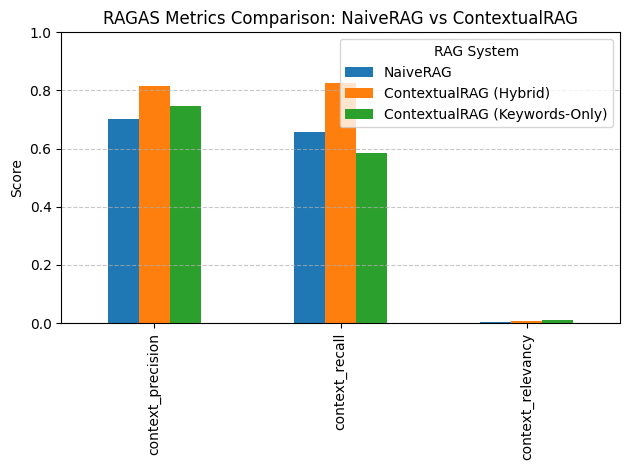

In [21]:
import matplotlib.pyplot as plt
# Visualize the comparison
plt.figure(figsize=(12, 8))
comparison_df.plot(kind='bar')
plt.title('RAGAS Metrics Comparison: NaiveRAG vs ContextualRAG')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='RAG System')
plt.tight_layout()
plt.savefig('rag_comparison.png', dpi=300)
plt.show()